# Lesson 5: Tool Calling with Pydantic Models and OpenAI

- Use Pydantic models to define tool schemas for OpenAI's tool calling API
- Register your tool with the API using a validated schema
- Handle tool calls and validate arguments with Pydantic
- Integrate LLM-driven workflows with your own Python functions and data sources


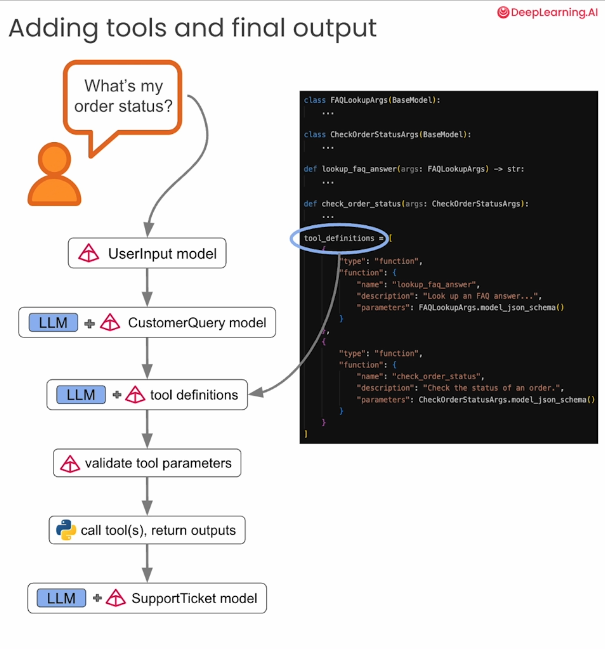
---

### Import all required libraries and set up your environment

In [1]:
# Import packages
from pydantic import BaseModel, Field, EmailStr, field_validator
from pydantic_ai import Agent
from typing import Literal, List, Optional
from datetime import datetime, date
import json
from openai import OpenAI
import anthropic
import instructor
from dotenv import load_dotenv
import os
load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
import nest_asyncio
nest_asyncio.apply()

### Define your Pydantic models for user input and LLM output

- @field_validator - This is a decorator function from Pydantic that can be used to validate a field using a custom function. This is very useful when the field structure might be complex. Can also be used to protect against SQL injection attacks.

In [2]:
# Define your UserInput model
class UserInput(BaseModel):
    name: str = Field(..., description="User's name")
    email: EmailStr = Field(..., description="User's email address")
    query: str = Field(..., description="User's query")
    order_id: Optional[str] = Field(
        None,
        description="Order ID if available (format: ABC-12345)"
    )
    # Validate order_id format (e.g., ABC-12345)
    @field_validator("order_id")
    def validate_order_id(cls, order_id):
        import re
        if order_id is None:
            return order_id
        pattern = r"^[A-Z]{3}-\d{5}$"
        if not re.match(pattern, order_id):
            raise ValueError(
                "order_id must be in format ABC-12345 "
                "(3 uppercase letters, dash, 5 digits)"
            )
        return order_id
    purchase_date: Optional[date] = None



In [3]:
# Define your CustomerQuery model
class CustomerQuery(UserInput):
    priority: str = Field(
        ..., description="Priority level: low, medium, high"
    )
    category: Literal[
        'refund_request', 'information_request', 'other'
    ] = Field(..., description="Query category")
    is_complaint: bool = Field(
        ..., description="Whether this is a complaint"
    )
    tags: List[str] = Field(..., description="Relevant keyword tags")

### Validate user input and create a CustomerQuery instance

In [4]:
# Define a function to validate user input
def validate_user_input(user_json: str):
    """Validate user input from a JSON string and return a UserInput 
    instance if valid."""
    try:
        user_input = (
            UserInput.model_validate_json(user_json)
        )
        print("user input validated...")
        return user_input
    except Exception as e:
        print(f" Unexpected error: {e}")
        return None

In [9]:
# Define a function to call an LLM using Pydantic AI to create an instance of CustomerQuery
def create_customer_query(valid_user_json: str) -> CustomerQuery:
    customer_query_agent = Agent(
        model="openai:gpt-4",
        output_type=CustomerQuery,
    )
    response = customer_query_agent.run_sync(valid_user_json)
    print("CustomerQuery generated...")
    return response.output

### Try out your validation and query creation with sample input

In [10]:
# Define user input JSON data
user_input_json = '''
{
    "name": "Joe User",
    "email": "joe@example.com",
    "query": "When can I expect delivery of the headphones I ordered?",
    "order_id": "ABC-12345",
    "purchase_date": "2025-12-01"
}
'''
# Validate user input and create a CustomerQuery
valid_data = validate_user_input(user_input_json).model_dump_json()
customer_query = create_customer_query(valid_data)
print(type(customer_query))
print(customer_query.model_dump_json(indent=2))

user input validated...
CustomerQuery generated...
<class '__main__.CustomerQuery'>
{
  "name": "Joe User",
  "email": "joe@example.com",
  "query": "When can I expect delivery of the headphones I ordered?",
  "order_id": "ABC-12345",
  "purchase_date": "2025-12-01",
  "priority": "medium",
  "category": "information_request",
  "is_complaint": false,
  "tags": [
    "delivery",
    "order status",
    "headphones"
  ]
}


### Define tool input models for FAQ lookup and order status

- The below pydantic model defines what type of arguments are expected by the FAQ lookup tools - which are query as well as tags - provided by the LLM

In [11]:
# Define FAQ Lookup tool input as a Pydantic model
class FAQLookupArgs(BaseModel):
    query: str = Field(..., description="User's query") 
    tags: List[str] = Field(
        ..., description="Relevant keyword tags from the customer query"
    )

- The below pydantic model defines what arguments are needed by the order status tool as a pydantic model

In [12]:
# Define Check Order Status tool input as a Pydantic model
class CheckOrderStatusArgs(BaseModel):
    order_id: str = Field(
        ..., description="Customer's order ID (format: ABC-12345)"
    )
    email: EmailStr = Field(..., description="Customer's email address")

    @field_validator("order_id")
    def validate_order_id(cls, order_id):
        import re
        pattern = r"^[A-Z]{3}-\d{5}$"
        if not re.match(pattern, order_id):
            raise ValueError(
                "order_id must be in format ABC-12345 "
                "(3 uppercase letters, dash, 5 digits)"
            )
        return order_id

### Create example FAQ and order databases

In [13]:
# Create a fake FAQ database as a list of entries with keywords
faq_db = [
    {
        "question": "How can I reset my password?",
        "answer": "To reset your password, click 'Forgot Password' on the sign-in page and follow the instructions sent to your email.",
        "keywords": ["password", "reset", "account"]
    },
    {
        "question": "How long does shipping take?",
        "answer": "Standard shipping takes 3-5 business days. You can track your order in your account dashboard.",
        "keywords": ["shipping", "delivery", "order", "tracking"]
    },
    {
        "question": "How can I return an item?",
        "answer": "You can return any item within 30 days of purchase. Visit our returns page to start the process.",
        "keywords": ["return", "refund", "exchange"]
    },
    {
        "question": "How can I delete my account?",
        "answer": "To delete your account, go to your account settings tab and select 'delete account'.",
        "keywords": ["delete", "account", "remove"]
    }
]

# Create a fake order database
order_db = {
    "ABC-12345": {
        "status": "shipped", "estimated_delivery": "2025-12-05",
        "purchase_date": "2025-12-01", "email": "joe@example.com"
    },
    "XYZ-23456": {
        "status": "processing", "estimated_delivery": "2025-12-15",
        "purchase_date": "2025-12-10", "email": "sue@example.com"
    },
    "QWE-34567": {
        "status": "delivered", "estimated_delivery": "2025-12-20",
        "purchase_date": "2025-12-18", "email": "bob@example.com"
    }
}

### Implement tool functions for FAQ lookup and order status

In [14]:
# Define your FAQ lookup tool
def lookup_faq_answer(args: FAQLookupArgs) -> str:
    """Look up an FAQ answer by matching tags and words in query 
    to FAQ entry keywords."""
    query_words = set(word.lower() for word in args.query.split())
    tag_set = set(tag.lower() for tag in args.tags)
    best_match = None
    best_score = 0
    for faq in faq_db:
        keywords = set(k.lower() for k in faq["keywords"])
        score = len(keywords & tag_set) + len(keywords & query_words)
        if score > best_score:
            best_score = score
            best_match = faq
    if best_match and best_score > 0:
        return best_match["answer"]
    return "Sorry, I couldn't find an FAQ answer for your question."

In [15]:
# Define your check order status tool
def check_order_status(args: CheckOrderStatusArgs):
    """Simulate checking the status of a customer's order by 
    order_id and email."""
    order = order_db.get(args.order_id)
    if not order:
        return {
            "order_id": args.order_id,
            "status": "not found",
            "estimated_delivery": None,
            "note": "order_id not found"
        }
    if args.email.lower() != order.get("email", "").lower():
        return {
            "order_id": args.order_id,
            "status": order["status"],
            "estimated_delivery": order["estimated_delivery"],
            "note": "order_id found but email mismatch"
        }
    return {
        "order_id": args.order_id,
        "status": order["status"],
        "estimated_delivery": order["estimated_delivery"],
        "note": "order_id and email match"
    }

### Define tool schemas for OpenAI tool calling

In [18]:
# Define tools for your API call
tool_definitions = [
    {
        "type": "function",
        "function": {
            "name": "lookup_faq_answer",
            "description": "Look up an FAQ answer by matching tags to FAQ entry keywords.",
            "parameters": FAQLookupArgs.model_json_schema() # Pydantic Data Model comes into picture to ensure it is passed to LLM as a part of tool definition
        }
    },
    {
        "type": "function",
        "function": {
            "name": "check_order_status",
            "description": "Check the status of a customer's order.",
            "parameters": CheckOrderStatusArgs.model_json_schema() # Pydantic Data Model comes into picture to ensure it is passed to LLM as a part of tool definitio
        }
    }
]

### Define your support ticket output model

#### Define your final output Pydantic models

In [19]:
#Define your final output Pydantic models
class OrderDetails(BaseModel):
    status: str
    estimated_delivery: str
    note: str

class SupportTicket(CustomerQuery):
    recommended_next_action: Literal[
        'escalate_to_agent', 'send_faq_response', 
        'send_order_status', 'no_action_needed'
    ] = Field(
        ..., description="LLM's recommended next action for support"
    )
    order_details: Optional[OrderDetails] = Field(
        None, description="Order details if action is send_order_status"
    )
    faq_response: Optional[str] = Field(
        None, description="FAQ response if action is send_faq_response"
    )
    creation_date: datetime = Field(
        ..., description="Date and time the ticket was created"
    )

### Decide on the next support action using OpenAI tool calling

In [20]:
# Initialize OpenAI client
client = OpenAI()

# Define a function to call OpenAI with tools
def decide_next_action_with_tools(customer_query: CustomerQuery):
    
    support_ticket_schema = json.dumps(
        SupportTicket.model_json_schema(), indent=2
    )
    system_prompt = f"""
        You are a helpful customer support agent. Your job is to 
        determine what support action should be taken for the customer, 
        based on the customer query and the expected fields in the 
        SupportTicket schema below. If more information on a particular 
        order_id or FAQ response would be helpful in responding to the 
        user query and can be obtained by calling a tool, call the 
        appropriate tool to get that information. If an order_id is 
        present in the query, always look up the order status to get 
        more information on the order.

        Here is the JSON schema for the SupportTicket model you must 
        use as context for what information is expected:
        {support_ticket_schema}
    """
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": str(customer_query.model_dump())}
    ]
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
        tools=tool_definitions,
        tool_choice="auto"
    )
    message = response.choices[0].message
    tool_calls = getattr(message, "tool_calls", None)
    return message, tool_calls, messages

### Inspect the LLM's outputs and tool calls

In [28]:
# Stage 1: Decide on next action: Call the decide_next_action_with_tools function
message, tool_calls, messages = decide_next_action_with_tools(
    customer_query
)
# Investigate the LLM's outputs before proceeding
print(
    "\nTool calls:\n", 
    json.dumps([call.model_dump() for call in tool_calls], indent=2)
)


Tool calls:
 [
  {
    "id": "call_LrGgntudofo7ANMF68Ft85gh",
    "function": {
      "arguments": "{\"order_id\":\"ABC-12345\",\"email\":\"joe@example.com\"}",
      "name": "check_order_status"
    },
    "type": "function"
  }
]


### Gather tool outputs and prepare for ticket generation

In [29]:
# Define a function to get tool outputs
def get_tool_outputs(tool_calls):
    tool_outputs = []
    if tool_calls:
        for tool_call in tool_calls:
            if tool_call.function.name == "lookup_faq_answer":
                print("Agent requested a call to the Lookup FAQ tool...")
                args = FAQLookupArgs.model_validate_json(
                    tool_call.function.arguments
                )
                result = lookup_faq_answer(args)
                tool_outputs.append({
                    "tool_call_id": tool_call.id, "output": result
                })
                print(f"Lookup FAQ tool returned {result}")
            elif tool_call.function.name == "check_order_status":
                print("Agent requested a call to Check Order Status tool...")
                args = CheckOrderStatusArgs.model_validate_json(
                    tool_call.function.arguments
                )
                result = check_order_status(args)
                tool_outputs.append({
                    "tool_call_id": tool_call.id, "output": result
                })
                print(f"Check Order Status tool returned {result}")
    return tool_outputs

# Stage 2: Gather any needed tool outputs and generate a support
# ticket (run this after inspecting above)
tool_outputs = get_tool_outputs(tool_calls)

# Print tool outputs for inspection
print("Tool outputs:\n", json.dumps(tool_outputs, indent=2))

Agent requested a call to Check Order Status tool...
Check Order Status tool returned {'order_id': 'ABC-12345', 'status': 'shipped', 'estimated_delivery': '2025-12-05', 'note': 'order_id and email match'}
Tool outputs:
 [
  {
    "tool_call_id": "call_LrGgntudofo7ANMF68Ft85gh",
    "output": {
      "order_id": "ABC-12345",
      "status": "shipped",
      "estimated_delivery": "2025-12-05",
      "note": "order_id and email match"
    }
  }
]


### Generate a structured support ticket using Anthropic

In [27]:
# Create the Anthropic client with Instructor
anthropic_client = instructor.from_anthropic(
    anthropic.Anthropic()
)

# Define a function to call Anthropic to generate a support ticket
def generate_structured_support_ticket(
    customer_query: CustomerQuery, message, tool_outputs: list
):
    tool_results_str = "\n".join([
        f"Tool: {out['tool_call_id']} Output: {json.dumps(out['output'])}"
        for out in tool_outputs
    ]) if tool_outputs else "No tool calls were made."
    # Concatenate prompt parts into a single string for Anthropic
    prompt = f"""
        You are a support agent. Use all information below to 
        generate a support ticket as a validated Pydantic model.
        Customer query: {customer_query.model_dump_json(indent=2)}
        LLM message: {str(message.content)}
        Tool results: {tool_results_str}
    """
    # Create the message with structured output
    response = anthropic_client.messages.create(
        model="claude-3-7-sonnet-latest",  
        max_tokens=1024,
        messages=[
            {
                "role": "user", 
                "content": prompt
            }
        ],
        response_model=SupportTicket
    )
    
    support_ticket = response
    support_ticket.creation_date = datetime.now()
    return support_ticket

### Print your final support ticket

In [30]:
# Run the final step of generating a support ticket and print output
support_ticket = generate_structured_support_ticket(
    customer_query, message, tool_outputs
)
print(support_ticket.model_dump_json(indent=2))

{
  "name": "Joe User",
  "email": "joe@example.com",
  "query": "When can I expect delivery of the headphones I ordered?",
  "order_id": "ABC-12345",
  "purchase_date": "2025-12-01",
  "priority": "medium",
  "category": "information_request",
  "is_complaint": false,
  "tags": [
    "delivery",
    "order status",
    "headphones"
  ],
  "recommended_next_action": "send_order_status",
  "order_details": {
    "status": "shipped",
    "estimated_delivery": "2025-12-05",
    "note": "order_id and email match"
  },
  "faq_response": null,
  "creation_date": "2025-10-22T17:52:38.413431"
}


### Full workflow: validate, query, decide, tool, and generate ticket

In [31]:
# Define new user input data
user_json = '''
{
    "name": "Joe User",
    "email": "joe@example.com",
    "query": "I'm really not happy with this product I bought",
    "order_id": "QWE-34567",
    "purchase_date": null
}
'''

In [32]:
# Run the entire pipeline
valid_user_json = validate_user_input(user_json).model_dump_json()
customer_query = create_customer_query(valid_user_json)
message, tool_calls, messages = decide_next_action_with_tools(
    customer_query
)
tool_outputs = get_tool_outputs(tool_calls)
support_ticket = generate_structured_support_ticket(
    customer_query, message, tool_outputs
)
print(support_ticket.model_dump_json(indent=2))

user input validated...
CustomerQuery generated...
Agent requested a call to Check Order Status tool...
Check Order Status tool returned {'order_id': 'QWE-34567', 'status': 'delivered', 'estimated_delivery': '2025-12-20', 'note': 'order_id found but email mismatch'}
{
  "name": "Joe User",
  "email": "joe@example.com",
  "query": "I'm really not happy with this product I bought",
  "order_id": "QWE-34567",
  "purchase_date": null,
  "priority": "high",
  "category": "refund_request",
  "is_complaint": true,
  "tags": [
    "product dissatisfaction",
    "refund"
  ],
  "recommended_next_action": "escalate_to_agent",
  "order_details": {
    "status": "delivered",
    "estimated_delivery": "2025-12-20",
    "note": "order_id found but email mismatch"
  },
  "faq_response": null,
  "creation_date": "2025-10-22T17:54:16.795432"
}
